# FL4ME: Federated Learning for Medical Diagnostics

This notebook provides comprehensive analysis and visualization of experiments comparing **Centralized** and **Federated Learning** approaches for breast cancer classification.

In medical diagnosis, **recall** is the most important metric because:
- **False negatives are dangerous**: Missing a cancer case can be life-threatening
- **Early detection saves lives**: High recall ensures we catch most true cases
- **Patient safety first**: Better to have false positives than miss actual cancer

This analysis gives special attention to recall performance across all approaches.

## 📋 Notebook Contents:

1. **Performance Metrics Comparison** - Side-by-side comparison of accuracy, precision, **recall**, and F1
2. **Recall Analysis** - Dedicated section highlighting recall performance (critical for medical diagnosis)
3. **Training Efficiency** - Analysis of training time vs performance trade-offs
4. **Federated Configuration Trade-offs** - Impact of local epochs vs server rounds on performance and efficiency
5. **Summary Statistics** - Key insights and best configurations with focus on recall
6. **Export Results** - Save results for reporting

## 🚀 Quick Start:

1. Run all cells in order
2. Results are fetched from W&B (optimal hyperparameters only)
3. Visualizations and insights are generated automatically
4. Results are exported to `results/` directory

---

## Setup & Data Loading

### Importing Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import os
from torchvision.transforms import Compose, Normalize, ToTensor
from medmnist import BreastMNIST
from torch.utils.data import DataLoader

# Import your model and utility functions
import sys
sys.path.append('..')
from FL4ME.task import Net, load_data, test

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

### Load Experimental Results

This notebook analyzes runs with **optimal hyperparameters only**:
- **Centralized**: lr=0.001, epochs=30
- **Federated**: lr=0.001, 30 total training steps (various round×epoch configurations)
- **Approaches**: FedAvg, FedProx, DP-FedAvg, DP-FedProx

We filter out hyperparameter search experiments and focus on production-ready configurations.

In [ ]:
# Fetch runs from WandB API with optimal hyperparameters
import wandb

try:
    api = wandb.Api()
    # Fetch runs from FL4ME project
    all_runs = api.runs("louisewiljander-ludwig-maximilianuniversity-of-munich/FL4ME")
    
    # Collect run data with all metrics
    run_data = []
    for run in all_runs:
        training_type = run.config.get('training_type', 'unknown')
        strategy = run.config.get('strategy', 'unknown')
        lr = run.config.get('lr', None)
        tags = run.tags if hasattr(run, 'tags') else []
        
            
        data = {
            'run_id': run.id,
            'name': run.name,
            'training_type': training_type,
            'strategy': strategy,
            'tags': ','.join(tags),
            'state': run.state,
            'lr': lr,
            'final_test_acc': run.summary.get('final_test_acc', None),
            'final_test_loss': run.summary.get('final_test_loss', None),
            'final_precision': run.summary.get('final_precision', None),
            'final_recall': run.summary.get('final_recall', None),
            'final_f1': run.summary.get('final_f1', None),
            'total_training_time_min': run.summary.get('total_training_time_min', None),
            'created_at': run.created_at,
        }
        
        # Add type-specific metrics
        if training_type == 'centralized':
            epochs = run.config.get('epochs', None)
            if epochs == 30:
                data['epochs'] = epochs
                data['total_steps'] = epochs
                data['approach'] = 'centralized'
            else:
                continue
        elif training_type == 'federated':
            data['num_rounds'] = run.config.get('num_rounds', None)
            data['local_epochs'] = run.config.get('local_epochs', None)
            data['total_local_epochs'] = run.config.get('total_local_epochs', None)
            data['total_steps'] = run.config.get('total_local_epochs', 0)
            
            
            # Determine approach from tags (matching actual WandB tags)
            if 'fedavg-dp' in strategy:
                data['approach'] = 'fedavg-dp'
            elif 'fedprox-dp' in strategy:
                data['approach'] = 'fedprox-dp'
            elif 'fedavg' in strategy:
                data['approach'] = 'fedavg'
            elif 'fedprox' in strategy:
                data['approach'] = 'fedprox'

            # Store DP and fedprox settings if applicable
            if '-dp' in data['approach']:
                data['noise_multiplier'] = run.config.get('noise_multiplier', None)
                data['clipping_norm'] = run.config.get('clipping_norm', None)
                data['dp_delta'] = run.config.get('dp_delta', None)
                data['dp_epsilon'] = run.summary.get('dp_epsilon', None)
            elif 'fedprox' in data['approach']:
                data['proximal_mu'] = run.config.get('proximal_mu', None)
        
        run_data.append(data)
    
    df_comparison = pd.DataFrame(run_data)
    df_comparison.to_csv('fl4me_optimal_results.csv', index=False)
    print(f"✅ Fetched {len(df_comparison)} runs with optimal hyperparameters from FL4ME")
    
except Exception as e:
    print(f"⚠️ Could not fetch from WandB: {e}")
    print("Trying to load from CSV...")
    try:
        df_comparison = pd.read_csv('fl4me_optimal_results.csv')
        print(f"✅ Loaded {len(df_comparison)} runs from CSV")
    except:
        print("❌ No data available")
        df_comparison = pd.DataFrame()

if not df_comparison.empty:
    # Ensure approach column exists (backward compatibility)
    if 'approach' not in df_comparison.columns:
        df_comparison['approach'] = df_comparison.apply(
            lambda x: 'centralized' if x['training_type'] == 'centralized' else 'fedavg', axis=1
        )
    
    print(f"\n\n📊 Data Summary (Filtered - Optimal Hyperparameters Only, No Random Search):")
    print(f"  Total runs after filtering: {len(df_comparison)}")
    
    print(f"\n  📊 Count per Strategy:")
    print("  " + "="*40)
    strategy_counts = df_comparison['approach'].value_counts().sort_index()
    for strategy, count in strategy_counts.items():
        print(f"  {strategy.upper():20s}: {count}")
    print("  " + "="*40)
    print(f"  {'TOTAL':20s}: {len(df_comparison)}")
    
    display_cols = ['name', 'approach', 'final_test_acc', 'final_recall', 'final_f1', 'total_training_time_min']
    print(f"\n  Top 10 runs by accuracy:")
    display(df_comparison[display_cols].sort_values('final_test_acc', ascending=False).head(10))

✅ Fetched 80 runs with optimal hyperparameters from FL4ME


📊 Data Summary (Filtered - Optimal Hyperparameters Only, No Random Search):
  Total runs after filtering: 80

  📊 Count per Strategy:
  CENTRALIZED         : 40
  FEDAVG              : 10
  FEDAVG-DP           : 10
  FEDPROX             : 10
  FEDPROX-DP          : 10
  TOTAL               : 80

  Top 10 runs by accuracy:


,name,approach,final_test_acc,final_recall,final_f1,total_training_time_min
24,central_lr0.001_ep30,centralized,0.881818,0.653846,0.723404,0.133692
38,central_lr0.001_ep30,centralized,0.881818,0.538462,0.682927,0.161994
29,central_lr0.001_ep30,centralized,0.881818,0.576923,0.697674,0.122689
25,central_lr0.001_ep30,centralized,0.872727,0.576923,0.681818,0.113602
6,central_lr0.001_ep30,centralized,0.872727,0.500000,0.650000,0.101651
37,central_lr0.001_ep30,centralized,0.872727,0.653846,0.708333,0.248233
14,central_lr0.001_ep30,centralized,0.872727,0.576923,0.681818,0.118908
20,central_lr0.001_ep30,centralized,0.872727,0.576923,0.681818,0.126468
11,central_lr0.001_ep30,centralized,0.872727,0.653846,0.708333,0.123278
12,central_lr0.001_ep30,centralized,0.872727,0.615385,0.695652,0.138762


## 1. Performance Metrics Comparison

Comprehensive comparison of all performance metrics across different federated learning approaches.

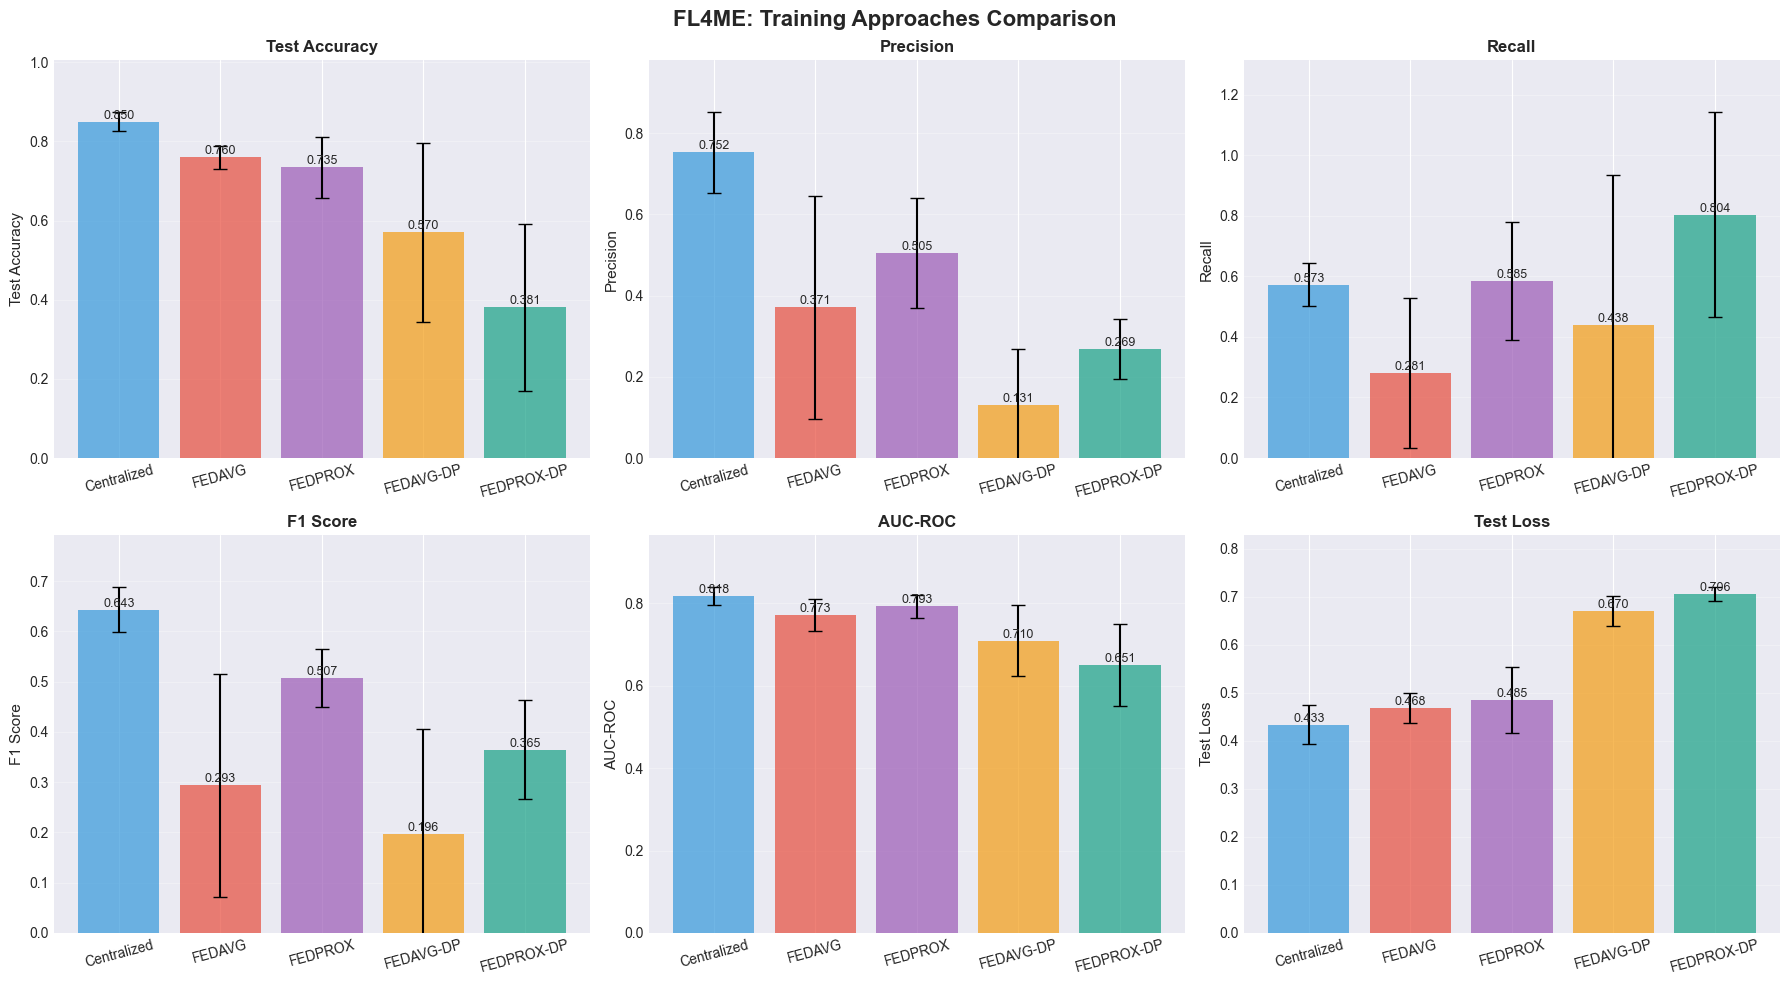


📊 Numerical Comparison (Mean ± Std):
Test Accuracy        | CENTRA: 0.850±0.024 | FEDAVG: 0.760±0.029 | FEDPRO: 0.735±0.078 | FEDAVG: 0.570±0.226 | FEDPRO: 0.381±0.211
Precision            | CENTRA: 0.752±0.099 | FEDAVG: 0.371±0.274 | FEDPRO: 0.505±0.135 | FEDAVG: 0.131±0.138 | FEDPRO: 0.269±0.074
Recall               | CENTRA: 0.573±0.070 | FEDAVG: 0.281±0.247 | FEDPRO: 0.585±0.196 | FEDAVG: 0.438±0.497 | FEDPRO: 0.804±0.338
F1 Score             | CENTRA: 0.643±0.044 | FEDAVG: 0.293±0.221 | FEDPRO: 0.507±0.058 | FEDAVG: 0.196±0.209 | FEDPRO: 0.365±0.098
AUC-ROC              | CENTRA: 0.818±0.022 | FEDAVG: 0.773±0.039 | FEDPRO: 0.793±0.029 | FEDAVG: 0.710±0.086 | FEDPRO: 0.651±0.099
Test Loss            | CENTRA: 0.433±0.041 | FEDAVG: 0.468±0.031 | FEDPRO: 0.485±0.068 | FEDAVG: 0.670±0.031 | FEDPRO: 0.706±0.014


In [ ]:
if not df_comparison.empty:
    # Filter by approach
    centralized_runs = df_comparison[df_comparison['approach'] == 'centralized']
    fedavg_runs = df_comparison[df_comparison['approach'] == 'fedavg']
    fedprox_runs = df_comparison[df_comparison['approach'] == 'fedprox']
    dp_fedavg_runs = df_comparison[df_comparison['approach'] == 'fedavg-dp']
    dp_fedprox_runs = df_comparison[df_comparison['approach'] == 'fedprox-dp']
    
    # Create comparison bar chart
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('FL4ME: Training Approaches Comparison', fontsize=16, fontweight='bold')
    
    metrics = [
        ('final_test_acc', 'Test Accuracy', axes[0, 0]),
        ('final_precision', 'Precision', axes[0, 1]),
        ('final_recall', 'Recall', axes[1, 0]), 
        ('final_f1', 'F1 Score', axes[1, 1])
    ]
    
    for metric, label, ax in metrics:
        x_labels = []
        y_vals = []
        err_vals = []
        colors = []
        
        # Collect data for each approach
        for approach, color in [('centralized', '#3498db'), ('fedavg', '#e74c3c'), 
                                 ('fedprox', '#9b59b6'), ('fedavg-dp', '#f39c12'), 
                                 ('fedprox-dp', '#16a085')]:
            approach_data = df_comparison[df_comparison['approach'] == approach]
            if not approach_data.empty and metric in approach_data.columns and approach_data[metric].notna().any():
                x_labels.append(approach.upper() if approach != 'centralized' else 'Centralized')
                y_vals.append(approach_data[metric].mean())
                err_vals.append(approach_data[metric].std())
                colors.append(color)
        
        if len(x_labels) > 0:
            bars = ax.bar(x_labels, y_vals, yerr=err_vals, capsize=5, alpha=0.7, color=colors)
            ax.set_ylabel(label, fontsize=11)
            ax.set_title(label, fontsize=12, fontweight='bold')
            
            # Adjust y-axis to show all data including error bars
            max_val = max([y + e for y, e in zip(y_vals, err_vals)])
            ax.set_ylim([0, max_val * 1.15])
            
            ax.grid(axis='y', alpha=0.3)
            ax.tick_params(axis='x', rotation=15)
            
            # Add value labels on bars
            for bar, val in zip(bars, y_vals):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{val:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print numerical comparison
    print("\n📊 Numerical Comparison (Mean ± Std):")
    print("="*120)
    for metric, label, _ in metrics:
        parts = [f"{label:20s}"]
        
        for approach in ['centralized', 'fedavg', 'fedprox', 'fedavg-dp', 'fedprox-dp']:
            approach_data = df_comparison[df_comparison['approach'] == approach]
            if not approach_data.empty and metric in approach_data.columns and approach_data[metric].notna().any():
                mean_val = approach_data[metric].mean()
                std_val = approach_data[metric].std()
                parts.append(f"{approach.upper()[:6]}: {mean_val:.3f}±{std_val:.3f}")
            else:
                parts.append(f"{'N/A':<18}")
        
        print(" | ".join(parts))
else:
    print("No comparison data available")

## 2. Recall Analysis - Critical for Medical Diagnosis

### ⚕️ Why Recall Matters in Breast Cancer Detection

**Recall (Sensitivity)** is especially important because:
- **False Negatives are Costly**: Missing a cancer case (false negative) can be life-threatening
- **Early Detection Saves Lives**: High recall ensures we catch most true cancer cases
- **Better Safe Than Sorry**: In medical contexts, it's better to have some false positives than to miss actual cases

**Trade-off**: While we aim for high recall, we also monitor precision to avoid excessive false alarms.

/var/folders/n4/4l9m_t6d49bg5p46d5j5tmzr0000gn/T/ipykernel_50901/1808381005.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=9, loc='lower right')


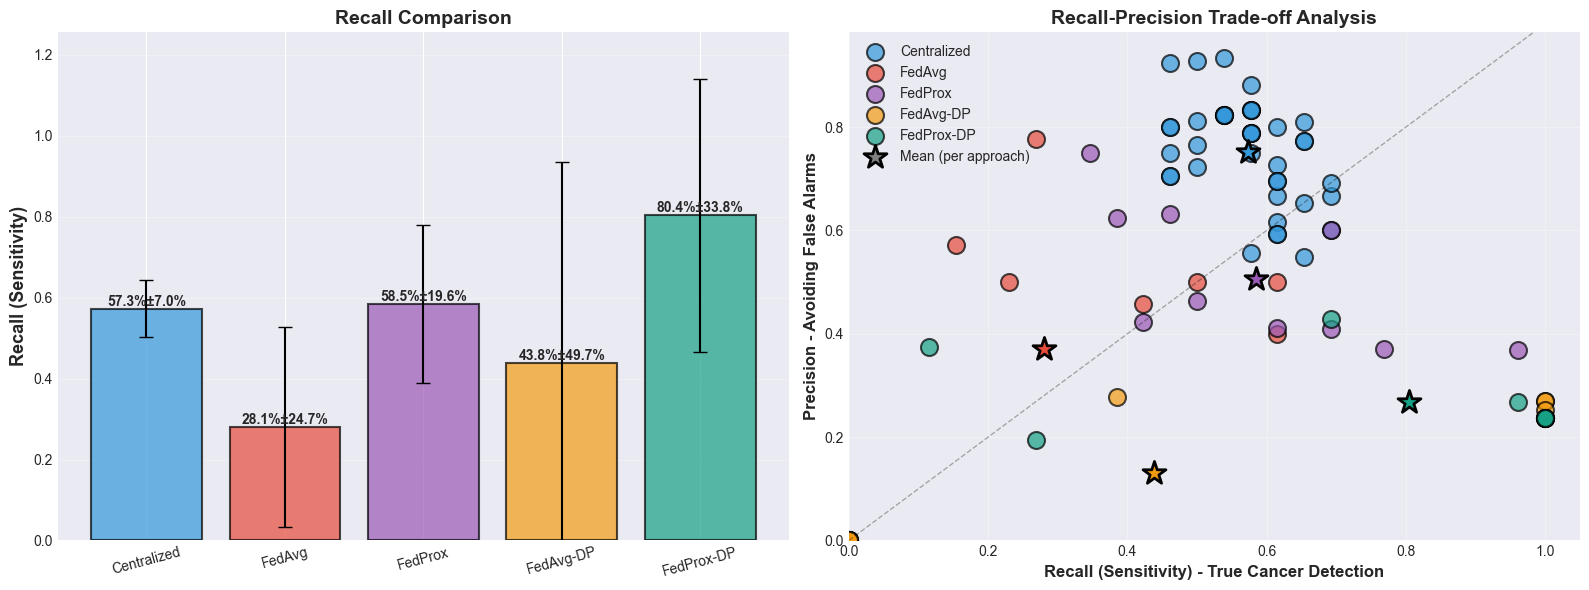


 RECALL ANALYSIS

Approach        Recall (Mean±Std)        
Centralized     0.5731 ± 0.0701
FedAvg          0.2808 ± 0.2466
FedProx         0.5846 ± 0.1959
FedAvg-DP       0.4385 ± 0.4973
FedProx-DP      0.8038 ± 0.3380

💡 Key Findings:
   • Best recall: FedProx-DP (80.4%)
     → Detects 80.4% of actual cancer cases
   • Lowest recall: FedAvg (28.1%)
     → Could miss 71.9% of actual cancer cases
   • Privacy cost on recall (FedAvg → DP-FedAvg): -15.8%
   • Privacy cost on recall (FedProx → DP-FedProx): -21.9%


In [48]:
if not df_comparison.empty:
    # Dedicated Recall Analysis for Medical Diagnosis
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Define colors for different approaches
    style_map = {
        'centralized': {'color': '#3498db', 'label': 'Centralized'},
        'fedavg': {'color': '#e74c3c', 'label': 'FedAvg'},
        'fedprox': {'color': '#9b59b6', 'label': 'FedProx'},
        'fedavg-dp': {'color': '#f39c12', 'label': 'FedAvg-DP'},
        'fedprox-dp': {'color': '#16a085', 'label': 'FedProx-DP'},
    }
    
    # Plot 1: Recall Comparison Bar Chart
    ax = axes[0]
    recall_data = []
    labels = []
    colors_list = []
    
    for approach in ['centralized', 'fedavg', 'fedprox', 'fedavg-dp', 'fedprox-dp']:
        approach_data = df_comparison[df_comparison['approach'] == approach]
        if not approach_data.empty and 'final_recall' in approach_data.columns and approach_data['final_recall'].notna().any():
            mean_val = approach_data['final_recall'].mean()
            std_val = approach_data['final_recall'].std() if len(approach_data) > 1 else 0
            recall_data.append((mean_val, std_val))
            labels.append(style_map[approach]['label'])
            colors_list.append(style_map[approach]['color'])
    
    if recall_data:
        means = [x[0] for x in recall_data]
        stds = [x[1] for x in recall_data]
        
        bars = ax.bar(labels, means, yerr=stds, capsize=5, alpha=0.7, color=colors_list,
                     edgecolor='black', linewidth=1.5)
        
        ax.set_ylabel('Recall (Sensitivity)', fontsize=13, fontweight='bold')
        ax.set_title('Recall Comparison', fontsize=14, fontweight='bold')
        
        # Set y-axis to accommodate all data including error bars
        # Ensure recall values of 1.0 are fully visible
        max_val = max([m + s for m, s in zip(means, stds)])
        ax.set_ylim([0.0, max(1.1, max_val * 1.1)])
        
        ax.grid(axis='y', alpha=0.3)
        ax.tick_params(axis='x', rotation=15)
        ax.legend(fontsize=9, loc='lower right')
        
        # Add value labels on bars
        for bar, mean, std in zip(bars, means, stds):
            height = bar.get_height()
            if std > 0:
                label_text = f'{mean:.1%}±{std:.1%}'
            else:
                label_text = f'{mean:.1%}'
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   label_text, ha='center', va='bottom', 
                   fontsize=10, fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'No recall data available', 
               ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title('Recall Comparison', fontsize=14, fontweight='bold')
    
    # Plot 2: Recall vs Precision Trade-off
    ax = axes[1]
    
    has_data = False
    all_recalls = []
    all_precisions = []
    
    for approach, style in style_map.items():
        approach_data = df_comparison[df_comparison['approach'] == approach]
        if (not approach_data.empty and 
            'final_recall' in approach_data.columns and 
            'final_precision' in approach_data.columns and
            approach_data['final_recall'].notna().any() and 
            approach_data['final_precision'].notna().any()):
            
            recall_vals = approach_data['final_recall'].dropna()
            precision_vals = approach_data['final_precision'].dropna()
            
            # Ensure same length
            min_len = min(len(recall_vals), len(precision_vals))
            recall_vals = recall_vals.iloc[:min_len]
            precision_vals = precision_vals.iloc[:min_len]
            
            if len(recall_vals) > 0:
                has_data = True
                all_recalls.extend(recall_vals.values)
                all_precisions.extend(precision_vals.values)
                
                # Plot each run as a point
                ax.scatter(recall_vals, precision_vals, s=150, alpha=0.7,
                          color=style['color'], label=style['label'],
                          edgecolor='black', linewidth=1.5)
                
                # Add mean as a larger marker
                ax.scatter(recall_vals.mean(), precision_vals.mean(), s=300,
                          color=style['color'], marker='*', edgecolor='black', linewidth=2)
    
    if has_data:
        ax.set_xlabel('Recall (Sensitivity) - True Cancer Detection', fontsize=12, fontweight='bold')
        ax.set_ylabel('Precision - Avoiding False Alarms', fontsize=12, fontweight='bold')
        ax.set_title('Recall-Precision Trade-off Analysis', fontsize=14, fontweight='bold')
        
        # Set dynamic axis limits based on data, ensuring recall values of 1.0 are visible
        min_recall = max(0, min(all_recalls) - 0.05)
        max_recall = min(1.05, max(all_recalls) + 0.05)
        min_precision = max(0, min(all_precisions) - 0.05)
        max_precision = min(1.05, max(all_precisions) + 0.05)
        
        ax.set_xlim([min_recall, max_recall])
        ax.set_ylim([min_precision, max_precision])
        
        # Add diagonal line showing F1 score
        diag_min = max(min_recall, min_precision)
        diag_max = min(max_recall, max_precision)
        x = np.linspace(diag_min, diag_max, 100)
        ax.plot(x, x, 'k--', alpha=0.3, linewidth=1)
        
        # Add dummy entry for star marker in legend
        ax.scatter([], [], s=300, marker='*', color='gray', edgecolor='black', 
                  linewidth=2, label='Mean (per approach)')
        
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10, loc='best')
    else:
        ax.text(0.5, 0.5, 'No precision-recall data available', 
               ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title('Recall-Precision Trade-off Analysis', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed recall analysis
    print("\n RECALL ANALYSIS\n")
    print("="*35)
    print(f"{'Approach':<15} {'Recall (Mean±Std)':<25}")
    print("="*35)
    
    found_any = False
    for approach in ['centralized', 'fedavg', 'fedprox', 'fedavg-dp', 'fedprox-dp']:
        approach_data = df_comparison[df_comparison['approach'] == approach]
        if not approach_data.empty and 'final_recall' in approach_data.columns and approach_data['final_recall'].notna().any():
            found_any = True
            mean_recall = approach_data['final_recall'].mean()
            std_recall = approach_data['final_recall'].std() if len(approach_data) > 1 else 0
            
        if std_recall > 0:
            print(f"{style_map[approach]['label']:<15} {mean_recall:.4f} ± {std_recall:.4f}")
        else:
            print(f"{style_map[approach]['label']:<15} {mean_recall:.4f}")
    
    if not found_any:
        print("   No recall data available for any approach")
    
    print("="*35)
    print("\n💡 Key Findings:")
    
    # Find best and worst recall
    best_recall_approach = None
    worst_recall_approach = None
    best_recall_val = 0
    worst_recall_val = 1
    
    for approach in ['centralized', 'fedavg', 'fedprox', 'fedavg-dp', 'fedprox-dp']:
        approach_data = df_comparison[df_comparison['approach'] == approach]
        if not approach_data.empty and 'final_recall' in approach_data.columns and approach_data['final_recall'].notna().any():
            mean_recall = approach_data['final_recall'].mean()
            if mean_recall > best_recall_val:
                best_recall_val = mean_recall
                best_recall_approach = style_map[approach]['label']
            if mean_recall < worst_recall_val:
                worst_recall_val = mean_recall
                worst_recall_approach = style_map[approach]['label']
    
    if best_recall_approach:
        print(f"   • Best recall: {best_recall_approach} ({best_recall_val:.1%})")
        print(f"     → Detects {best_recall_val*100:.1f}% of actual cancer cases")
    
    if worst_recall_approach:
        missed_cases = (1 - worst_recall_val) * 100
        print(f"   • Lowest recall: {worst_recall_approach} ({worst_recall_val:.1%})")
        print(f"     → Could miss {missed_cases:.1f}% of actual cancer cases")
    
    # Privacy impact on recall
    fedavg_data = df_comparison[df_comparison['approach'] == 'fedavg']
    dp_fedavg_data = df_comparison[df_comparison['approach'] == 'fedavg-dp']
    if (not fedavg_data.empty and not dp_fedavg_data.empty and 
        'final_recall' in fedavg_data.columns and 'final_recall' in dp_fedavg_data.columns):
        if fedavg_data['final_recall'].notna().any() and dp_fedavg_data['final_recall'].notna().any():
            recall_drop = fedavg_data['final_recall'].mean() - dp_fedavg_data['final_recall'].mean()
            print(f"   • Privacy cost on recall (FedAvg → DP-FedAvg): {recall_drop:.1%}")
    
    fedprox_data = df_comparison[df_comparison['approach'] == 'fedprox']
    dp_fedprox_data = df_comparison[df_comparison['approach'] == 'fedprox-dp']
    if (not fedprox_data.empty and not dp_fedprox_data.empty and 
        'final_recall' in fedprox_data.columns and 'final_recall' in dp_fedprox_data.columns):
        if fedprox_data['final_recall'].notna().any() and dp_fedprox_data['final_recall'].notna().any():
            recall_drop = fedprox_data['final_recall'].mean() - dp_fedprox_data['final_recall'].mean()
            print(f"   • Privacy cost on recall (FedProx → DP-FedProx): {recall_drop:.1%}")

## 3. Training Efficiency Analysis

Comparing training time and computational efficiency across approaches.

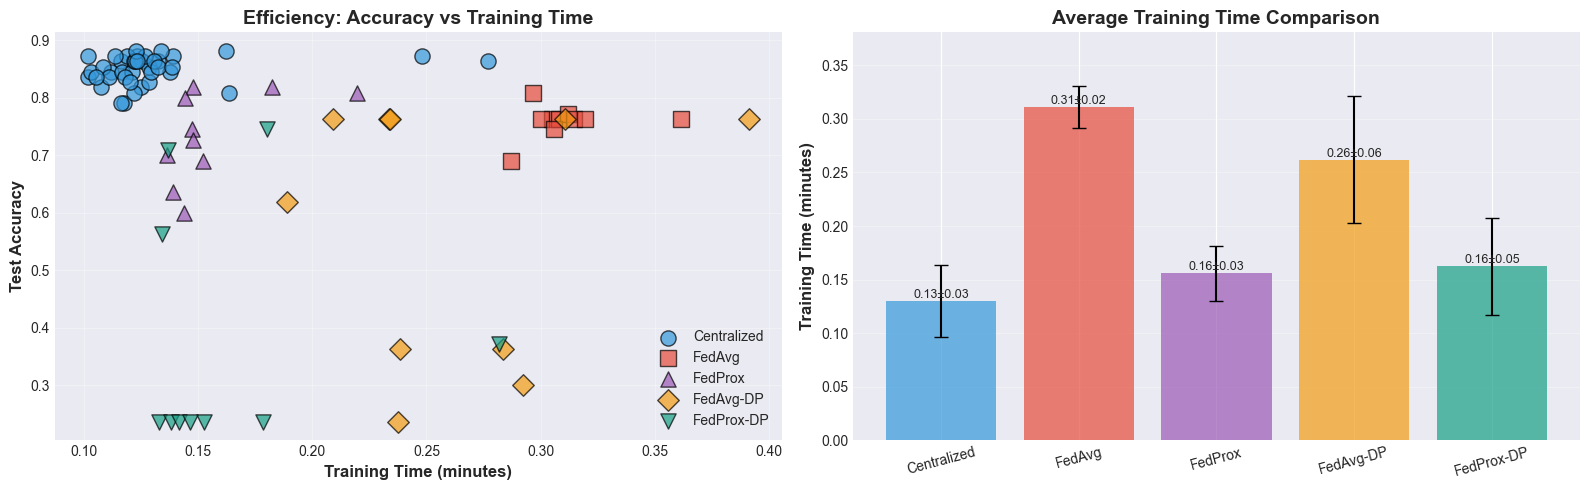


⏱️ Training Efficiency:
  Centralized: 0.13 ± 0.03 minutes
  FedAvg: 0.31 ± 0.02 minutes
  FedProx: 0.16 ± 0.03 minutes
  FedAvg-DP: 0.26 ± 0.06 minutes
  FedProx-DP: 0.16 ± 0.05 minutes


In [60]:
if not df_comparison.empty:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Plot 1: Accuracy vs Training Time
    ax = axes[0]
    
    style_map = {
        'centralized': {'color': '#3498db', 'marker': 'o', 'label': 'Centralized'},
        'fedavg': {'color': '#e74c3c', 'marker': 's', 'label': 'FedAvg'},
        'fedprox': {'color': '#9b59b6', 'marker': '^', 'label': 'FedProx'},
        'fedavg-dp': {'color': '#f39c12', 'marker': 'D', 'label': 'FedAvg-DP'},
        'fedprox-dp': {'color': '#16a085', 'marker': 'v', 'label': 'FedProx-DP'},
    }
    
    for approach, style in style_map.items():
        data = df_comparison[df_comparison['approach'] == approach]
        if not data.empty:
            ax.scatter(data['total_training_time_min'], data['final_test_acc'],
                      s=120, alpha=0.7, edgecolor='black', linewidth=1, **style)
    
    ax.set_xlabel('Training Time (minutes)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
    ax.set_title('Efficiency: Accuracy vs Training Time', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Training time comparison
    ax = axes[1]
    
    time_data = []
    labels = []
    colors_list = []
    
    for approach in ['centralized', 'fedavg', 'fedprox', 'fedavg-dp', 'fedprox-dp']:
        approach_data = df_comparison[df_comparison['approach'] == approach]
        if not approach_data.empty and 'total_training_time_min' in approach_data.columns and approach_data['total_training_time_min'].notna().any():
            time_data.append((approach_data['total_training_time_min'].mean(),
                             approach_data['total_training_time_min'].std()))
            labels.append(style_map[approach]['label'])
            colors_list.append(style_map[approach]['color'])
    
    if time_data:
        means = [x[0] for x in time_data]
        stds = [x[1] for x in time_data]
        
        bars = ax.bar(labels, means, yerr=stds, capsize=5, alpha=0.7, color=colors_list)
        
        ax.set_ylabel('Training Time (minutes)', fontsize=12, fontweight='bold')
        ax.set_title('Average Training Time Comparison', fontsize=14, fontweight='bold')
        
        # Adjust y-axis to show all data including error bars
        max_val = max([m + s for m, s in zip(means, stds)])
        ax.set_ylim([0, max_val * 1.15])
        
        ax.grid(axis='y', alpha=0.3)
        ax.tick_params(axis='x', rotation=15)
        
        for bar, mean, std in zip(bars, means, stds):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{mean:.2f}±{std:.2f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print("\n⏱️ Training Efficiency:")
    for approach in ['centralized', 'fedavg', 'fedprox', 'fedavg-dp', 'fedprox-dp']:
        approach_data = df_comparison[df_comparison['approach'] == approach]
        if not approach_data.empty and 'total_training_time_min' in approach_data.columns and approach_data['total_training_time_min'].notna().any():
            mean_time = approach_data['total_training_time_min'].mean()
            std_time = approach_data['total_training_time_min'].std()
            print(f"  {style_map[approach]['label']}: {mean_time:.2f} ± {std_time:.2f} minutes")
else:
    print("No timing data available")

## 4. Federated Configuration Analysis

Comparing different federated learning configurations: rounds vs local epochs trade-offs.

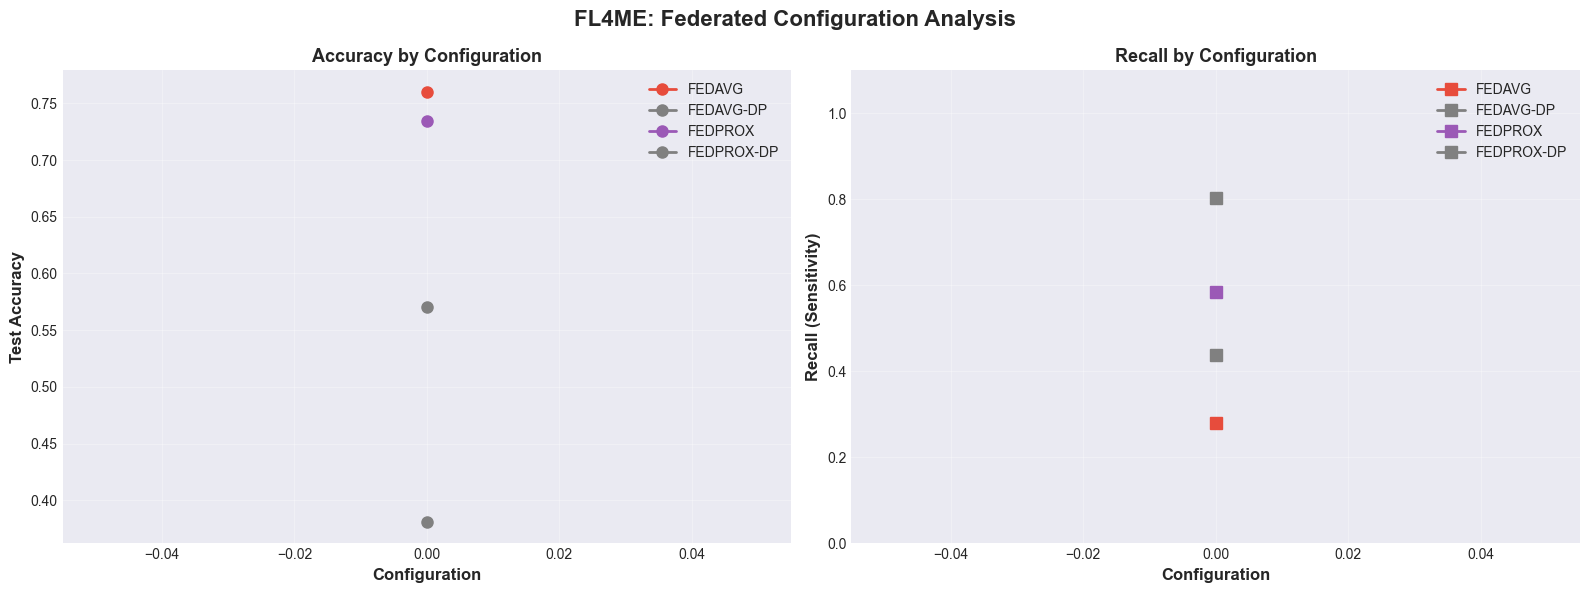


📋 Federated Configuration Summary:
FEDAVG       | 3×10 | Acc: 0.760 | Recall: 0.281
FEDAVG-DP    | 3×10 | Acc: 0.570 | Recall: 0.438
FEDPROX      | 3×10 | Acc: 0.735 | Recall: 0.585
FEDPROX-DP   | 3×10 | Acc: 0.381 | Recall: 0.804


In [54]:
if not df_comparison.empty:
    federated_only = df_comparison[df_comparison['training_type'] == 'federated'].copy()
    
    if not federated_only.empty and len(federated_only) > 1:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('FL4ME: Federated Configuration Analysis', fontsize=16, fontweight='bold')
        
        # Plot 1: Configuration comparison by approach
        ax = axes[0]
        
        # Group by configuration
        config_summary = federated_only.groupby(['num_rounds', 'local_epochs', 'approach']).agg({
            'final_test_acc': 'mean',
            'final_recall': 'mean'
        }).reset_index()
        
        # Plot each approach
        colors = {'fedavg': '#e74c3c', 'fedprox': '#9b59b6', 
                  'dp-fedavg': '#f39c12', 'dp-fedprox': '#16a085'}
        
        for approach in config_summary['approach'].unique():
            data = config_summary[config_summary['approach'] == approach]
            config_labels = [f"{int(r)}×{int(le)}" for r, le in zip(data['num_rounds'], data['local_epochs'])]
            ax.plot(range(len(data)), data['final_test_acc'], marker='o', linewidth=2,
                   label=approach.upper(), color=colors.get(approach, 'gray'), markersize=8)
        
        ax.set_xlabel('Configuration', fontsize=12, fontweight='bold')
        ax.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
        ax.set_title('Accuracy by Configuration', fontsize=13, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Plot 2: Recall by configuration
        ax = axes[1]
        
        for approach in config_summary['approach'].unique():
            data = config_summary[config_summary['approach'] == approach]
            ax.plot(range(len(data)), data['final_recall'], marker='s', linewidth=2,
                   label=approach.upper(), color=colors.get(approach, 'gray'), markersize=8)
        
        ax.set_xlabel('Configuration', fontsize=12, fontweight='bold')
        ax.set_ylabel('Recall (Sensitivity)', fontsize=12, fontweight='bold')
        ax.set_title('Recall by Configuration', fontsize=13, fontweight='bold')
        
        # Ensure recall values of 1.0 are fully visible
        max_recall = config_summary['final_recall'].max() if len(config_summary) > 0 else 1.0
        ax.set_ylim([0.0, max(1.1, max_recall * 1.05)])
        
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print configuration details
        print("\n📋 Federated Configuration Summary:")
        print("="*90)
        for _, row in config_summary.iterrows():
            print(f"{row['approach'].upper():12s} | {int(row['num_rounds'])}×{int(row['local_epochs'])} | "
                  f"Acc: {row['final_test_acc']:.3f} | Recall: {row['final_recall']:.3f}")
    else:
        print("Insufficient federated runs for configuration analysis")
else:
    print("No federated data available")

## 5. Export Results for Reporting

In [ ]:
# Export summary results to files
if not df_comparison.empty:
    os.makedirs('results', exist_ok=True)
    
    # Export full comparison data
    df_comparison.to_csv('results/fl4me_full_comparison.csv', index=False)
    print("✅ Exported full comparison to: results/fl4me_full_comparison.csv")
    
    # Export summary statistics
    summary_stats = []
    
    for approach in df_comparison['approach'].unique():
        subset = df_comparison[df_comparison['approach'] == approach]
        if not subset.empty:
            stats = {
                'approach': approach,
                'count': len(subset),
                'mean_test_acc': subset['final_test_acc'].mean(),
                'std_test_acc': subset['final_test_acc'].std(),
                'mean_precision': subset['final_precision'].mean(),
                'mean_recall': subset['final_recall'].mean(),
                'std_recall': subset['final_recall'].std(),
                'mean_f1': subset['final_f1'].mean(),
                'mean_training_time_min': subset['total_training_time_min'].mean(),
                'std_training_time_min': subset['total_training_time_min'].std(),
            }
            
            # Add best run info
            best_run = subset.nlargest(1, 'final_test_acc').iloc[0]
            stats['best_run_name'] = best_run['name']
            stats['best_run_acc'] = best_run['final_test_acc']
            stats['best_run_recall'] = best_run['final_recall']
            stats['best_run_time'] = best_run['total_training_time_min']
            
            summary_stats.append(stats)
    
    summary_df = pd.DataFrame(summary_stats)
    summary_df.to_csv('results/fl4me_summary_statistics.csv', index=False)
    print("✅ Exported summary statistics to: results/fl4me_summary_statistics.csv")
    
    # Export federated configurations
    federated_data = df_comparison[df_comparison['approach'] != 'centralized']
    if not federated_data.empty and 'num_rounds' in federated_data.columns:
        federated_configs = federated_data[['name', 'approach', 'num_rounds', 'local_epochs', 
                                             'final_test_acc', 'final_recall', 'final_f1', 
                                             'total_training_time_min']].copy()
        federated_configs = federated_configs.sort_values('final_recall', ascending=False)  # Sort by recall
        federated_configs.to_csv('results/fl4me_federated_configurations.csv', index=False)
        print("✅ Exported federated configurations to: results/fl4me_federated_configurations.csv")
    
    print("\n📁 All FL4ME results exported to the 'results/' directory")
    print("\n🎉 Analysis complete! Review the visualizations and exported data above.")
else:
    print("No data to export")

✅ Exported full comparison to: results/fl4me_full_comparison.csv
✅ Exported summary statistics to: results/fl4me_summary_statistics.csv
✅ Exported federated configurations to: results/fl4me_federated_configurations.csv

📁 All FL4ME results exported to the 'results/' directory

🎉 Analysis complete! Review the visualizations and exported data above.
